# Percettrone

## Dataset

Generiamo un dataset giocattolo per sperimentare con un classificatore percettrone

In [4]:
import pandas as pd
import numpy as np


def generate_dataset(n, dim, threshold=0.75):
    # Generate n points in dim-dimensional space // Matrix of random numbers
    points = np.random.rand(n, dim)

    # Create a DataFrame from the matrix of points
    df = pd.DataFrame(points)

    # Assign column names [x0..xDim]
    df.columns = ['x{}'.format(i) for i in range(dim)]

	# Set the target column depending on the sum of all the values in a certain row
    # - If the sum of all the attributes is below the threshold (0.75) then 0 otherwise 1
    df["label"] = np.where(df.sum(axis="columns") < threshold, 0, 1)

    return df

In [5]:
# Generate the dataframe using the function above
df = generate_dataset(1000, 2, 0.75)

In [6]:
# Print dataframe row to check the values / target label is correct
print(df.loc[[3]])

        x0        x1  label
3  0.65697  0.295162      1


## Dataset exploration

In [7]:
df.head(30)

,x0,x1,label
0,0.047277,0.589885,0
1,0.817372,0.407219,1
2,0.376380,0.736055,1
3,0.656970,0.295162,1
4,0.330758,0.474566,1
5,0.203193,0.774963,1
6,0.270275,0.469242,0
7,0.881980,0.188385,1
8,0.221081,0.533329,1
9,0.133444,0.037124,0


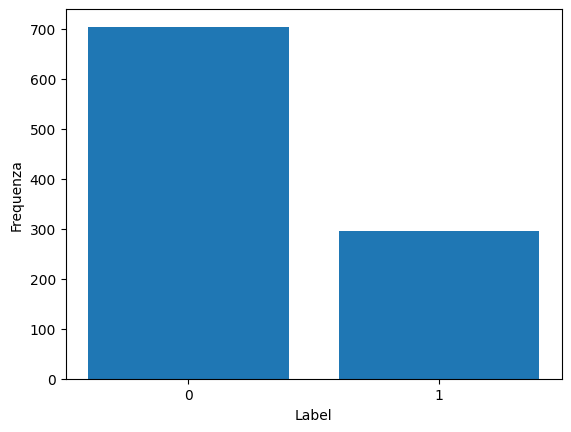

In [8]:
import matplotlib.pyplot as plt

# Unique label values on the X axis, Value counts on the Y axis
plt.bar(df["label"].unique(), df["label"].value_counts())
plt.ylabel("Frequenza")
plt.xlabel("Label")
plt.xticks([0, 1])
plt.show()

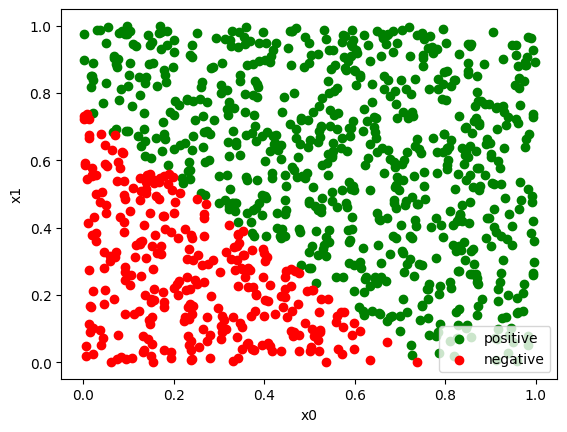

In [9]:
# dividiamo il DataFrame in due sotto-DataFrame in base alla label
df_pos = df[df['label'] == 1]
df_neg = df[df['label'] == 0]

# plot degli scatter plot per i due sotto-DataFrame
fig, ax = plt.subplots()
ax.scatter(df_pos['x0'], df_pos['x1'], c='green', label='positive')
ax.scatter(df_neg['x0'], df_neg['x1'], c='red', label='negative')

ax.legend()
ax.set_xlabel('x0')
ax.set_ylabel('x1')

plt.show()

In questo laboratorio dovrai **implementare il percettrone (tradizionale)** e il **percettrone (delta rule)**, seguendo questo pseudocodice:
<br><br>

**def** funzione(data, threshold) {

1. Initialize the weights: w0=-threshold, w1,w2 random

2. Set a control variable for convergence

3. Check convergency: all instances should be correctly classified.

   3. a. Adjust weights for misclassified instances

4. return weights

}

In [10]:
from pandas import DataFrame

def perceptron(data: DataFrame, threshold: float):
    input = data[['x0', 'x1']]
    target = data['label'].to_numpy()

    # Learning rate
    rate = 0.2

    # initialize bias weight
    w0 = -threshold

    # initialize weights
    w = np.random.rand(input.columns.size)

    # Control Variables
    converged = False
    tcount = 0

    while (not converged and tcount < 4000):
        converged = True
        for instance in range(len(input.index)):
            sum = w0

            # compute perceptron output
            for i in range(input.ndim):
                sum += input.values[instance][i] * w[i]

            perc_out = 0 if sum < 0 else 1


            #if actual output is different from expected output -> update weights with the perceptron rule
            if (target[instance] != perc_out):
                converged = False
                #print("w: {}".format(w))
                w0 = w0 + rate*(target[instance]-perc_out)*1
                for i in range(input.ndim):
                    #print("comp: targets {}-{}, input:{}".format(perc_out, target[instance], input.values[instance][i]))
                    w[i] = w[i] + rate*(target[instance]-perc_out)*input.values[instance][i]
        tcount += 1

    if (converged):
        print("CONVERGED!")
    elif (tcount >= 4000):
        print("FUCKING DEAD")

    return [w0, *w]

perceptron(df, 0.75)

CONVERGED!


[np.float64(-4.150000000000001),
 np.float64(5.538188093176612),
 np.float64(5.531128103050276)]

In [ ]:
from pandas import DataFrame

# get the gradient based on the Min Squared Error cost function
def gradient_of(target, x, w0, w):
    common = (target - w0 + w[0]*x[0] + w[1]*x[1])
    return [
        common * (-1),
        common * (x[0]),
        common * (x[1])
    ]

def compute_loss_function(target, x, w0, w):
    # Compute perceptron output
    perc_out = w0
    for i in range(len(x)):
        perc_out += w[i] + x[i]

    # Mean Squared Error (no need to sum cause output is in R^1)
    return 0.5*(target - perc_out)**2


def delta_perceptron(data: DataFrame, threshold: float):
    input = data[['x0', 'x1']]
    target = data['label'].to_numpy()

    # Learning rate
    rate = 0.001

    # initialize bias weight
    w0 = -threshold

    # initialize weights
    w = np.random.rand(input.columns.size)

    converged = False
    tcount = 0

    while (not converged and tcount < 1000):
        
        for instance in range(len(input.index)):
            
            gradient = gradient_of(target[instance], input.values[instance], w0, w)

            # Update weights
            w0 = w0 - rate * gradient[0]
            for i in range(input.ndim):
                w[i] = w[i] - rate * gradient[i+1]

        tcount += 1

        mse = compute_loss_function(target[0], input.values[0], w0, w)
        print(mse)

        if (mse < 0.001):
            converged = True
    
    if (tcount >= 1000):
        print("Fucking Dead")
    elif (converged):
        print("Converged!")

            
            

delta_perceptron(df, 0.75)

0.10844112469992057
0.15374987080297853
0.1994310550685393
0.24704824892095573
0.296541480138418
0.3474737807514843
0.3993707929719973
0.45180142652418237
0.5043916828842911
0.5568224187031736
0.6088238071532635
0.6601695669826062
0.7106716388703976
0.7601754160718621
0.8085555056029063
0.8557119706405509
0.9015670035340333
0.9460619827234602
0.9891548715211597
1.0308179211437833
1.0710356444073217
1.1098030301071504
1.1471239713348718
1.183009883870275
1.2174784933661924
1.250552772348519
1.2822600101126655
1.3126310004367452
1.3416993336745489
1.369500781258355
1.3960727619517341
1.4214538803621197
1.4456835292671222
1.468801548240566
1.4908479318962242
1.5118625818091291
1.531885096836754
1.5509545971528245
1.5691095778333413
1.5863877883037771
1.6028261343751462
1.6184605999695683
1.633326185968237
1.6474568639105436
1.6608855425368159
1.6736440454013861
1.685763097991508
1.6972723229730946
1.7082002423493259
1.7185742854645567
1.7284208019164222
1.737765078554233
1.746631359844659